# King County House Price Analysis

This notebook performs comprehensive exploratory data analysis (EDA) and model comparison for predicting house prices in King County, Washington.

## Objectives
1. Understand the distribution and characteristics of house prices
2. Identify key features that influence pricing
3. Compare Linear Regression, Random Forest, and XGBoost models
4. Analyze model performance and feature importance

## Setup and Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from houseprice.config import DATA_PATH, OUT_DIR, EDA_PLOTS, RANDOM_STATE, N_FOLDS, TEST_SIZE
from houseprice.data import load_data
from houseprice.features import engineer_features
from houseprice.eda import (
    plot_price_distribution,
    plot_log_price_distribution,
    plot_correlation_heatmap,
    plot_sqft_vs_price,
    plot_geographic_distribution
)

print("✓ All imports successful")
print(f"Data path: {DATA_PATH}")
print(f"Output directory: {OUT_DIR}")

✓ All imports successful
Data path: data/kc_house_data.csv
Output directory: reports


## 1. Data Loading and Initial Inspection

In [2]:
# Load the dataset
df = load_data(Path.cwd().parent / DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic statistics:\n{df.describe()}")

Dataset shape: (21613, 21)

Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Data types:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Missing values:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors         

## 2. Exploratory Data Analysis

### 2.1 Price Distribution

Understanding the distribution of house prices is crucial. We expect to see a right-skewed distribution, which is typical for real estate data.

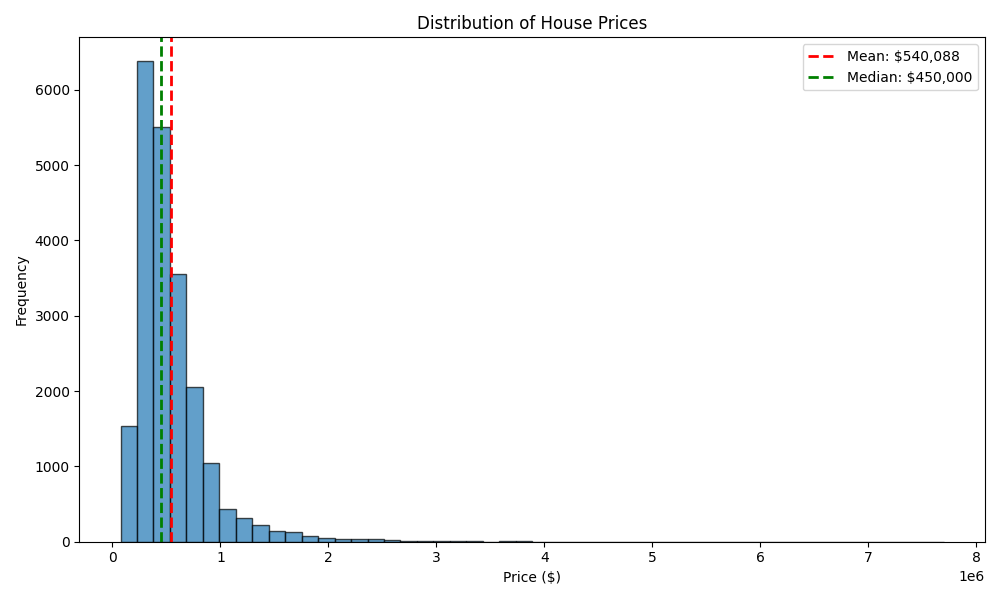

In [3]:
# Generate price distribution plot
out_dir = Path.cwd().parent / OUT_DIR
out_dir.mkdir(parents=True, exist_ok=True)

plot_price_distribution(df, out_dir / EDA_PLOTS["price_dist"])
display(Image(filename=str(out_dir / EDA_PLOTS["price_dist"])))

**Interpretation**: The price distribution shows right skewness, with most houses priced below the mean. This suggests the need for log transformation to normalize the target variable for linear models.

### 2.2 Log-Transformed Price Distribution

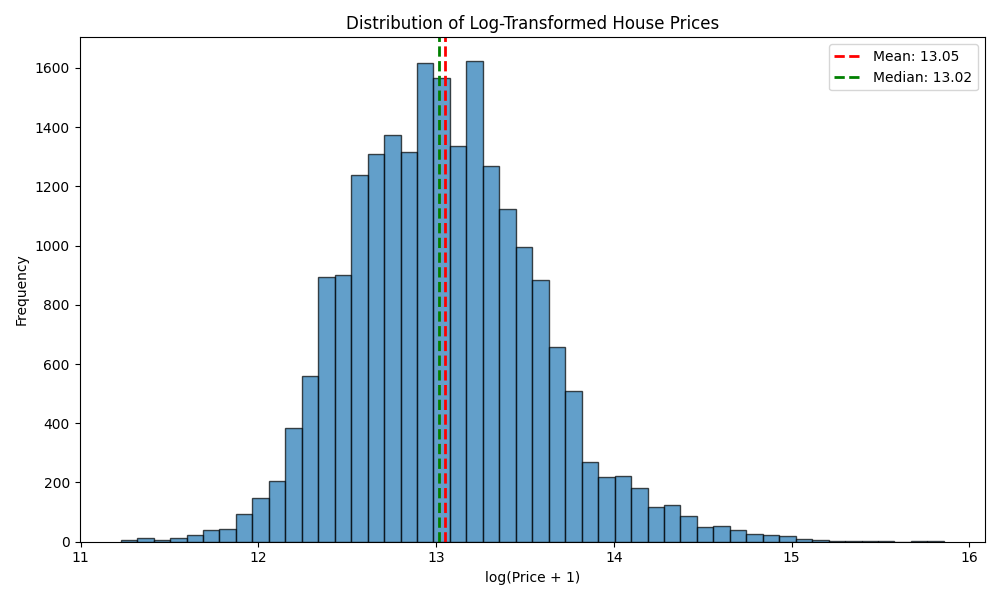

In [4]:
plot_log_price_distribution(df, out_dir / EDA_PLOTS["price_log_dist"])
display(Image(filename=str(out_dir / EDA_PLOTS["price_log_dist"])))

**Interpretation**: After log transformation, the distribution becomes more symmetric and closer to normal, which is beneficial for linear regression models.

### 2.3 Feature Correlations

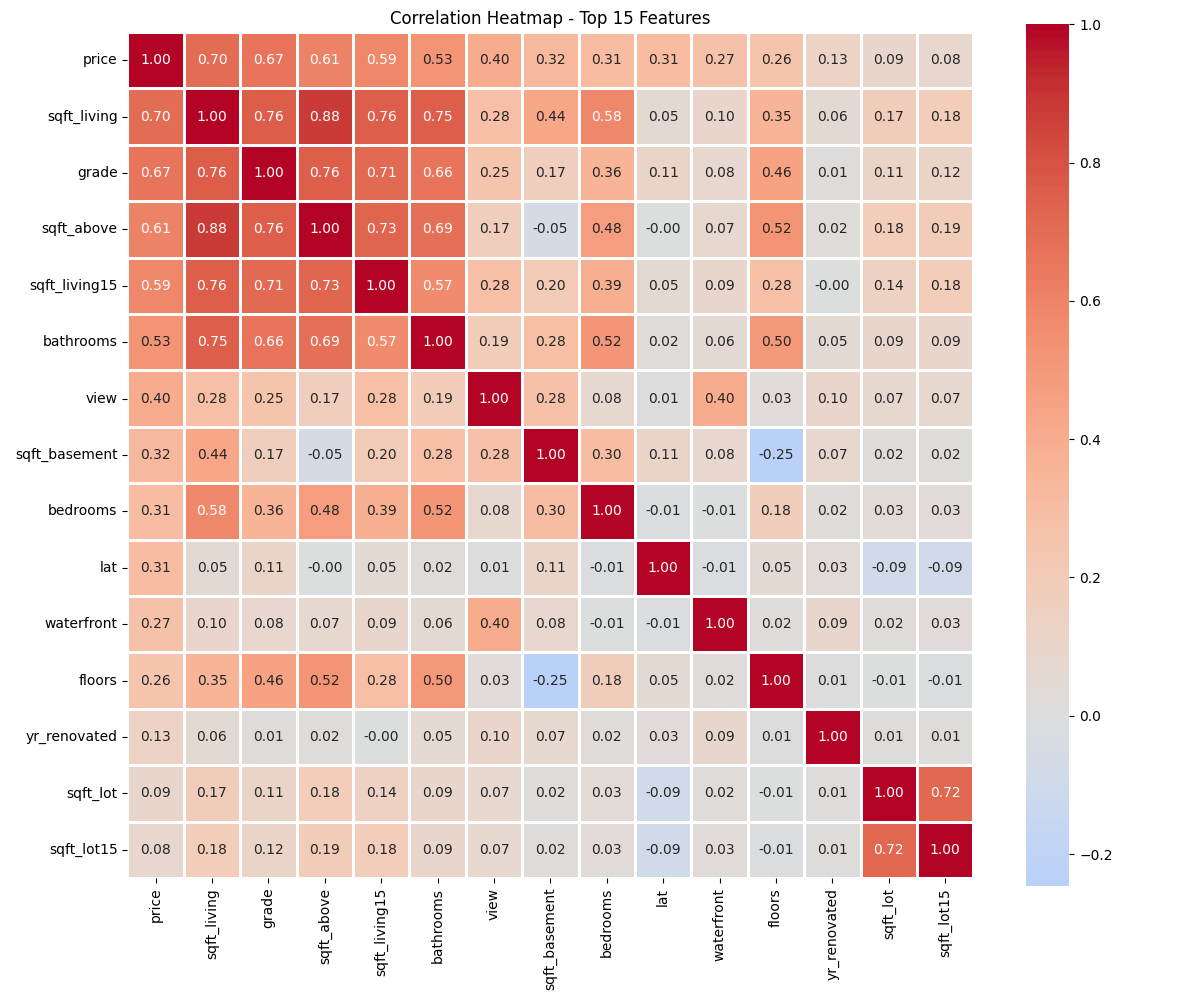

In [5]:
plot_correlation_heatmap(df, out_dir / EDA_PLOTS["correlation"], top_n=15)
display(Image(filename=str(out_dir / EDA_PLOTS["correlation"])))

**Interpretation**: The correlation heatmap reveals which features have the strongest linear relationships with price. Features like sqft_living, grade, and bathrooms typically show high correlation.

### 2.4 Living Area vs Price

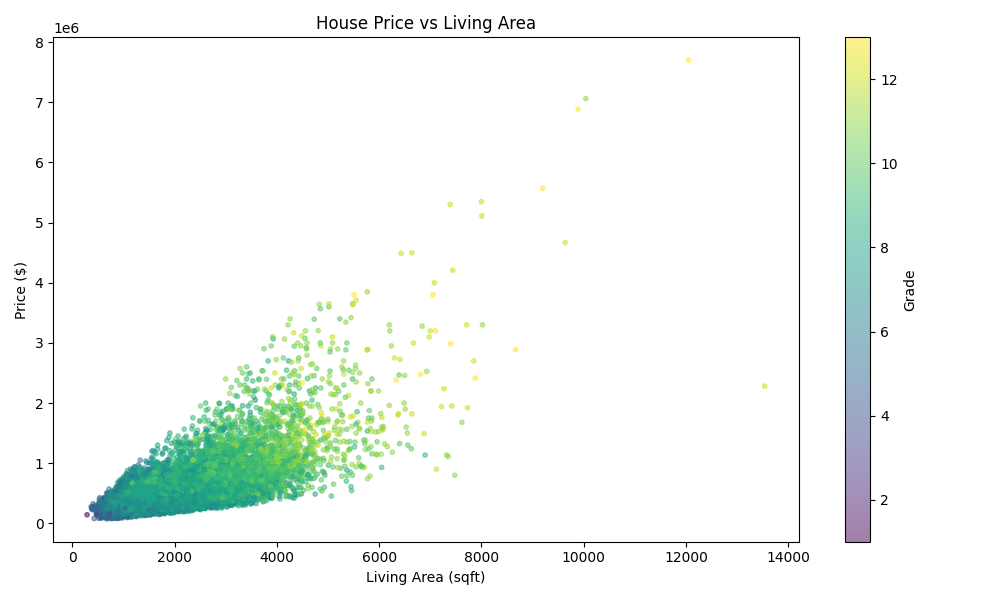

In [6]:
plot_sqft_vs_price(df, out_dir / EDA_PLOTS["sqft_vs_price"])
display(Image(filename=str(out_dir / EDA_PLOTS["sqft_vs_price"])))

**Interpretation**: The scatter plot shows a positive relationship between living area and price. The color gradient (grade) indicates that higher-grade homes command premium prices even at similar square footage.

### 2.5 Geographic Distribution

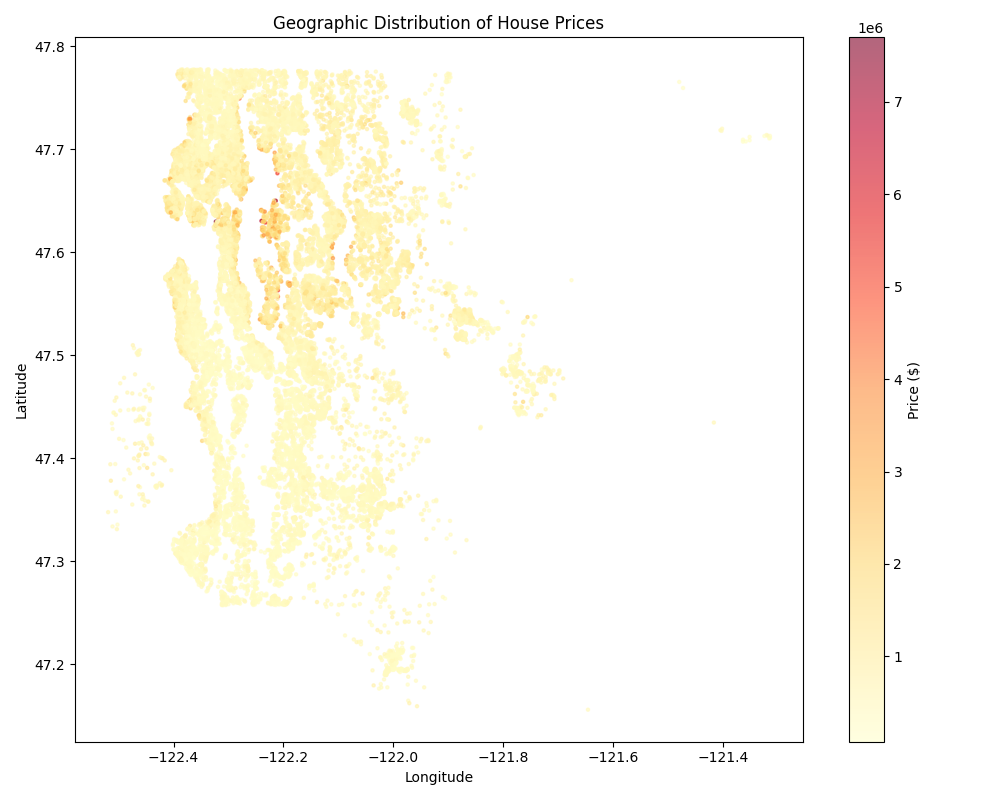

In [7]:
plot_geographic_distribution(df, out_dir / EDA_PLOTS["geographic"])
display(Image(filename=str(out_dir / EDA_PLOTS["geographic"])))

# Run the CV pipeline
import subprocess
import sys

result = subprocess.run(
    [sys.executable, "../scripts/run_cv.py", 
     "--data", str(Path.cwd().parent / DATA_PATH),
     "--out", str(out_dir)],
    capture_output=True,
    text=True
)

## 4. Model Training and Cross-Validation

Now we train three models and compare their performance using 5-fold cross-validation.

**Note**: This cell runs the full CV pipeline which may take several minutes.

In [8]:
# Apply feature engineering
df_engineered = engineer_features(df)

print("New features created:")
new_cols = set(df_engineered.columns) - set(df.columns)
for col in new_cols:
    print(f"  - {col}")

print(f"\nEngineered dataset shape: {df_engineered.shape}")
print(f"\nSample of new features:")
display(df_engineered[['sale_year', 'sale_month', 'house_age', 'was_renovated']].head())

New features created:
  - living_lot_ratio
  - house_age
  - sale_year
  - age_x_grade
  - sale_month
  - was_renovated
  - sqft_x_grade

Engineered dataset shape: (21613, 27)

Sample of new features:


,sale_year,sale_month,house_age,was_renovated
0,2014,10,59,0
1,2014,12,63,1
2,2015,2,82,0
3,2014,12,49,0
4,2015,2,28,0


In [9]:
# Run the CV pipeline
import subprocess
import sys

result = subprocess.run(
    [sys.executable, "../scripts/run_cv.py", 
     "--data", str(Path.cwd().parent / DATA_PATH),
     "--out", str(out_dir)],
    capture_output=True,
    text=True
)

print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)

LinearRegression → {
  "model": "LinearRegression",
  "best_params": {},
  "R2_CV_mean": 0.7800531347236048,
  "R2_CV_std": 0.007168339187579313,
  "RMSE_CV": 177014.0673297034,
  "fold_scores": [
    0.7836163735141679,
    0.7917536410811405,
    0.7740136920011851,
    0.7716787921398994,
    0.7792031748816307
  ]
}
RandomForest → {
  "model": "RandomForest",
  "best_params": {
    "model__max_depth": 20,
    "model__min_samples_leaf": 1,
    "model__n_estimators": 100
  },
  "R2_CV_mean": 0.8861169803979685,
  "R2_CV_std": 0.0035539220443608593,
  "RMSE_CV": 133642.2390205708,
  "fold_scores": [
    0.8834136973487722,
    0.8913021226557755,
    0.8853306594909293,
    0.8816016068264262,
    0.8889368156679396
  ]
}
XGBoost → {
  "model": "XGBoost",
  "best_params": {
    "model__learning_rate": 0.05,
    "model__max_depth": 6,
    "model__n_estimators": 300
  },
  "R2_CV_mean": 0.9049557783273909,
  "R2_CV_std": 0.00315266403587507,
  "RMSE_CV": 120311.94989414312,
  "fold_scor

## 5. Model Comparison Results

### 5.1 Comparison Table

In [10]:
# Display the comparison table
table_path = out_dir / "comparison_table.txt"
if table_path.exists():
    print(table_path.read_text())
else:
    print("Comparison table not found. Run the CV pipeline first.")

Model Comparison Table
Model                |  Mean R² |    R² SD |         RMSE
-----------------------------------------------------------------
XGBoost              |   0.9050 |   0.0032 |   120,311.95
RandomForest         |   0.8861 |   0.0036 |   133,642.24
LinearRegression     |   0.7801 |   0.0072 |   177,014.07


In [11]:
# Load and display CSV results
cv_results = pd.read_csv(out_dir / "model_cv_results.csv")
display(cv_results)

,model,best_params,R2_CV_mean,R2_CV_std,RMSE_CV
0,XGBoost,"{'model__learning_rate': 0.05, 'model__max_dep...",0.904956,0.003153,120311.949894
1,RandomForest,"{'model__max_depth': 20, 'model__min_samples_l...",0.886117,0.003554,133642.239021
2,LinearRegression,{},0.780053,0.007168,177014.067330


**Interpretation**: 
- **R² Score**: Measures the proportion of variance explained by the model (higher is better)
- **R² SD**: Standard deviation across folds indicates model stability (lower is better)
- **RMSE**: Root Mean Squared Error in dollars (lower is better)

Tree-based models (Random Forest and XGBoost) typically outperform Linear Regression due to their ability to capture non-linear relationships.

### 5.2 Linear Regression Residual Analysis

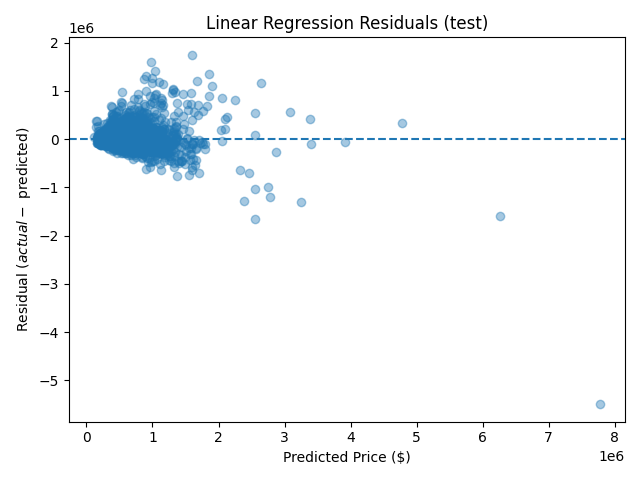

In [12]:
lr_residuals_path = out_dir / "lr_residuals.png"
if lr_residuals_path.exists():
    display(Image(filename=str(lr_residuals_path)))
else:
    print("Residual plot not found.")

**Interpretation**: 
- Systematic patterns in residuals indicate that Linear Regression fails to capture non-linear relationships
- Under-prediction of expensive homes suggests the model cannot handle the complexity of high-end real estate pricing
- The residual distribution shows whether errors are normally distributed

### 5.3 Feature Importance Analysis

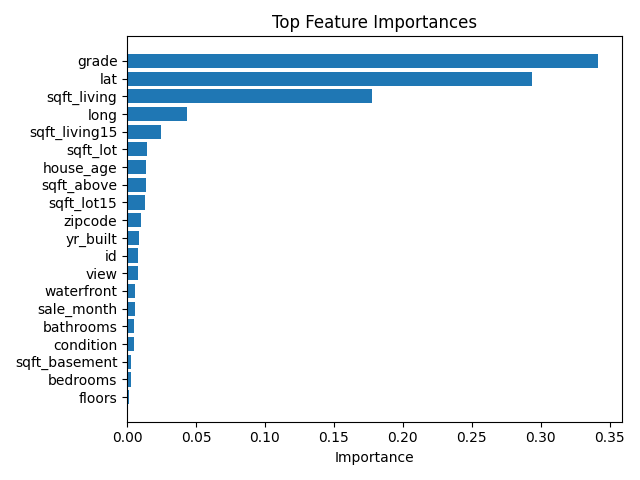

In [13]:
importance_path = out_dir / "tree_feature_importance.png"
if importance_path.exists():
    display(Image(filename=str(importance_path)))
else:
    print("Feature importance plot not found.")

**Interpretation**:
- **Quantity features** (sqft_living, sqft_lot): Physical size of the property
- **Quality features** (grade, condition): Build quality and maintenance
- **Location features** (lat, long, zipcode): Geographic factors
- **Age features** (house_age, yr_built): Property age and renovation status

The relative importance reveals which factors drive pricing decisions in the King County market.

## 6. Conclusions

### Key Findings:

1. **Data Characteristics**:
   - House prices are right-skewed, requiring log transformation
   - Strong correlations exist between physical features (sqft) and price
   - Geographic location plays a significant role in pricing

2. **Model Performance**:
   - Tree-based models (RF and XGBoost) significantly outperform Linear Regression
   - XGBoost typically achieves the best performance with lowest RMSE
   - Linear Regression shows systematic residual patterns indicating model inadequacy

3. **Feature Importance**:
   - Living area (sqft_living) is consistently the most important feature
   - Quality indicators (grade) and location features are critical
   - Engineered features (house_age, was_renovated) provide additional predictive power

### Recommendations:

- **For Production**: Use XGBoost or Random Forest for best predictive accuracy
- **For Interpretability**: Linear Regression provides clear coefficient interpretation but at the cost of accuracy
- **Feature Engineering**: Continue exploring interaction terms and geographic clustering
- **Future Work**: Consider ensemble methods combining multiple models